<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Mickael/notebooks/U_Net_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [ ]:
!pip install nussl

In [ ]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

In [ ]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np
import concurrent.futures
import time

# Montage du drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Récupération des données

In [5]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

Exemple :

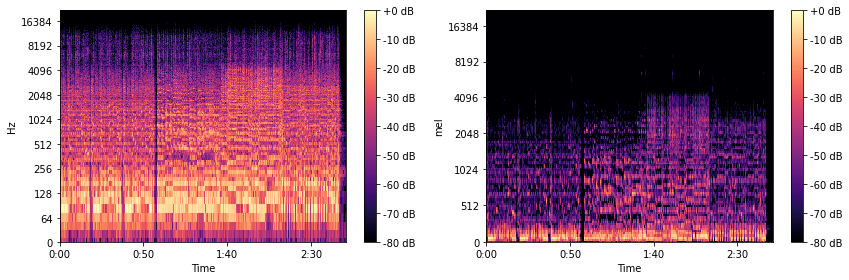

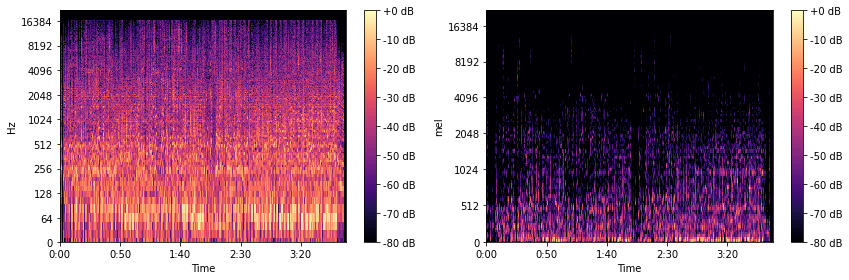

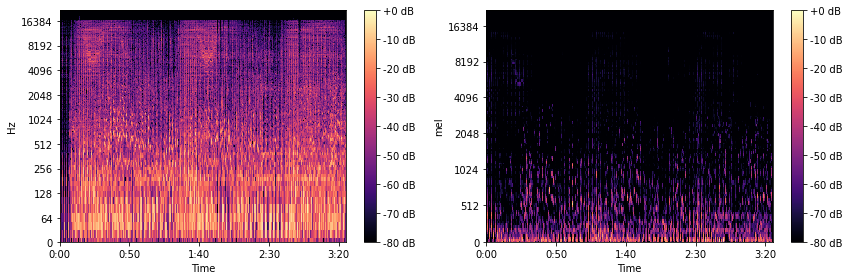

In [ ]:
for i in range(3):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis='log')
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis="mel")
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Définition de fonctions utiles

Une fonction pour le préprocessing des données :
- rééchantillonage,
- passage en mono,
- STFT et séparation magnitude et phase.

In [6]:
def preprocess(music_data,
               freq=8192,
               window_length=1023,
               hop_length=768,
               normalize=True):
  
  # Spectro voix et mix
  voice = music_data['sources']["vocals"]
  mix = music_data['mix']

  # Resampling à 16 kHz (pour data plus light)
  if freq is not None:
    voice.resample(freq,res_type='kaiser_fast')
    mix.resample(freq,res_type='kaiser_fast')

  # Passage en mono
  voice.to_mono()
  mix.to_mono()

  # fft mix et voix (magnitude normalisée et phase)
  stftvoice = voice.stft(window_length=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = mix.stft(window_length=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  if normalize:
    norm = magmix.max()
    magmix /= norm
    magvoice /= norm
    return magmix, magvoice, phasemix, norm

  return magmix, magvoice, phasemix

Une fonction pour reshape les données.

Des tableaux 2D ($n_{freq} \times n_{t}$) sont pris en entrée.

Les spectrogrammes sont découpés en tronçons de même tailles et une dimension de canal est ajoutée. La sortie est donc de dimension $n_{tronçons} \times n_{t}' \times n_{freq} \times n_{canal}$, où $n_{t}'$ correspond à un `patch_size` choisi par l'utilisateur et $n_{canal} = 1$.

In [7]:
def reshape(X_mix, X_voice, patch_size=128):
  # transposition pour mettre le temps en première composante  
  X_mix = X_mix.T
  X_voice = X_voice.T

  # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
  nimages = X_mix.shape[0]//patch_size   # nombre total d'images
  newsize = nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

  X_mix_resized = X_mix[:newsize]
  X_voice_resized = X_voice[:newsize]

  X_mix = np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
  X_voice = np.array(np.split(X_voice_resized, nimages, axis=0))

  X_mix = np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
  X_voice = np.expand_dims(X_voice,axis=3)

  return X_mix, X_voice

In [10]:
def reshape(X_mix, X_voice, patch_size=128):
  # transposition pour mettre le temps en première composante
  X_mix = X_mix.T
  X_voice = X_voice.T

  # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
  nimages = X_mix.shape[0]//patch_size*5   # nombre total d'images

  X_mix_rand = []
  X_voice_rand = []
  for _ in range(nimages):
    rand = np.random.randint(patch_size,X_mix.shape[0])
    X_mix_rand.append(X_mix[rand-patch_size:rand])
    X_voice_rand.append(X_voice[rand-patch_size:rand])

  X_mix_rand = np.expand_dims(X_mix_rand,axis=3) # rajout d'une dimension (canal) 
  X_voice_rand = np.expand_dims(X_voice_rand,axis=3)

  return X_mix_rand, X_voice_rand

In [5]:
import numpy as np
a = np.zeros((1000,512))
b = []
rand = np.random.randint(128,1000)
b.append(a[rand-128:rand])
np.array(b).shape

(1, 128, 512)

Enfin, un générateur de données est créé pour permettre l'entrainement d'un réseau de neurone sans engorger la RAM.

Nous allons d'abord mettre en place la structure nécessaire au multithreading.

In [ ]:
# Multithreading and multiprocessing test : Lancement de 5 fonctions qui durent 2 secondes
def f(i):
  time.sleep(2)
  return i

res = []
t = time.time()
for i in range(5):
  res.append(f(i))
print(f"Sequential : {time.time()-t}s")
print(f"Result : {res}")

t = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
  threads = []
  for i in range(5):
    threads.append(executor.submit(f, i))
  res = [t.result() for t in threads]
print(f"Multithreaded : {time.time()-t}s")
print(f"Result : {res}")

t = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
  threads = []
  for i in range(5):
    threads.append(executor.submit(f, i))
  res = [t.result() for t in threads]
print(f"Multiprocessed : {time.time()-t}s")
print(f"Result : {res}")
print(f"(By default, google allows to use 2 CPU)")

Sequential : 10.010613203048706s
Result : [0, 1, 2, 3, 4]
Multithreaded : 2.0044145584106445s
Result : [0, 1, 2, 3, 4]
Multiprocessed : 6.226722717285156s
Result : [0, 1, 2, 3, 4]
(By default, google allows to use 2 CPU)


Notre problème est majoritairement CPU-bound (limité par la puissance de calcul), notamment lors de la première epoch (lecture des audios, stft, etc...).

Le multiprocessing est donc plus adapté que le multithreading.

Par défaut, Colab nous permet d'accéder à deux CPU, ce qui permet de diviser le temps par deux mais ajoute un overhead.

De plus, la réalisation de trop de tâches en parallèle risque de saturer la RAM, que l'on contrôle difficilement grâce au générateur.

Peu de gain est à espérer, mais on propose d'utiliser un multiprocessing que nous contraindrons à 3 workers max. Nous n'utiliserons la parallélisation **que** lorsque les données ne sont pas lues en cache. 

In [8]:
def get_data(all_data, num, freq, window_length, hop_length, cache_on_disk, cache_path):

  magmix, magvoice, *_ = preprocess(all_data[num], freq, window_length, hop_length)
  magmix = magmix[:,:,0]
  magvoice = magvoice[:,:,0]
  if cache_on_disk:
    os.mkdir(cache_path)
    np.save(os.path.join(cache_path,"magmix.npy"), magmix)
    np.save(os.path.join(cache_path,"magvoice.npy"), magvoice)
  return magmix, magvoice

De nombreux paramètres sont disponibles, notamment la possibilité de stocker les données sur le disque (argument `cache_on_disk`), ce qui permet de très fortement accélérer la lecture des données dès la deuxième epoch.

In [9]:
def data_generator(all_data,
                   batch_size = 10,
                   nfreq = 512,
                   freq = 8192,
                   window_length = 1023,
                   hop_length = 768,
                   patch_size = 128,
                   cache_on_disk = False,
                   cache_dir = os.path.join("/content","cache"),
                   randomize_batches = True,
                   min_max = None,
                   parallel = True,
                   max_workers = None):
  # Mix as input, voice as output
  if cache_on_disk and not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
  magmixes, magvoices = {},{}
  if min_max is None:
    min = 0
    max = len(all_data)
  else:
    min, max = min_max
  my_range = np.arange(min,max)

  with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    workers = {}
    counts = []
    while True:

      if randomize_batches:
        np.random.shuffle(my_range)

      for count,num in enumerate(my_range):

        counts.append(count)
        cache_path = os.path.join(cache_dir,f"{num}_{freq}_{window_length}_{hop_length}")
        if cache_on_disk and os.path.exists(cache_path):
          magmix = np.load(os.path.join(cache_path,"magmix.npy"))
          magvoice = np.load(os.path.join(cache_path,"magvoice.npy"))
          magmixes[count] = magmix
          magvoices[count] = magvoice
        else:
          func = get_data
          args = (all_data, num, freq, window_length, hop_length, cache_on_disk, cache_path)
          if parallel:
            workers[count] = executor.submit(func, *args)
          else:
            magmix, magvoice = func(*args)
            magmixes[count] = magmix
            magvoices[count] = magvoice

        if((count+1)%batch_size == 0 or count+1 == len(my_range)):

          if parallel:
            results = {i:w.result() for i,w in workers.items()}
            for i in results.keys():
              magmixes[i] = results[i][0]
              magvoices[i] = results[i][1]
          X_mix = np.concatenate([magmixes[i] for i in counts], axis=1)
          X_voice = np.concatenate([magvoices[i] for i in counts], axis=1)
          X_mix, X_voice = reshape(X_mix, X_voice, patch_size)

          yield X_mix, X_voice

          X_mix, X_voice = None, None
          magmixes, magvoices = {}, {}
          workers = {}
          counts = []

Petite vérification de la shape obtenue sur un exemple rapide.

In [ ]:
a = data_generator(musdb_train,
                   batch_size=5,
                   cache_on_disk=True,
                   randomize_batches=False,
                   min_max = None,
                   parallel = True)
print("Testing, should be (81, 128, 512, 1)")
import time
t = time.time()
print(next(a)[0].shape)
print(f"Took {time.time()-t}s")

Testing, should be (81, 128, 512, 1)
(81, 128, 512, 1)
Took 57.232537031173706s


# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

## Définition et entrainement du réseau

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU, Activation

# Rem. dimensionnement du papier  nframes=128 nfreq=512

nframes = 128
nfreq = 512
batch_size = 1
val_ratio = 0.1
val_batch_size = 5

n_train = int(len(musdb_train)*(1-val_ratio))
n_train=90
data_gen = data_generator(musdb_train,
                          batch_size=batch_size,
                          patch_size=nframes,
                          cache_on_disk=True,
                          randomize_batches = True,
                          min_max = (0,90),
                          max_workers = 1)
val_gen = data_generator(musdb_train,
                         batch_size=val_batch_size,
                         patch_size=nframes,
                         cache_on_disk=True,
                         randomize_batches = False,
                         min_max = (90,100),
                         max_workers = 1)

# Création de la structure

inputs=Input(shape =(nframes,nfreq,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (5,5), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 512, kernel_size = (5,5), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)
mask     = Activation(activation='sigmoid')(deconv12)

outputs = tf.multiply(inputs,mask)

unet = Model(inputs=inputs, outputs=outputs)
unet.summary()

#essai sur la norme du spectre direct (pas de masque)

#définition de la loss function 
def myloss(y_true, y_pred):
  return tf.math.reduce_mean(abs(y_true - y_pred)) + abs(tf.math.reduce_mean(y_true) - tf.math.reduce_mean(y_pred))

earlyStop = tf.keras.callbacks.EarlyStopping(
    patience=50,
    restore_best_weights=True,
)

temp_gen = data_generator(musdb_train,
                          batch_size=1,
                          patch_size=nframes,
                          cache_on_disk=True,
                          randomize_batches = False,
                          min_max = (95,100),
                          max_workers = 1)
all_X = [next(temp_gen) for _ in range(5)]

class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, model, X_mix, X_voice):
    self.model = model
    self.X_mix = X_mix
    self.X_voice = X_voice

  def on_train_batch_end(self, batch, logs={}):
    ytest = self.model.predict(self.X_mix.reshape(-1,128,512,1))
    print()
    print(np.mean([np.mean(np.abs(y_true - y_pred))+abs(np.mean(y_true) - np.mean(y_pred))
           for y_true,y_pred in zip(self.X_voice,ytest)]))

  #def on_epoch_end(self, epoch, logs={}):
  #  print("True voice")
  #  plt.figure(figsize=(20,7))
  #  mix_to_plot = np.concatenate([X_voice_i for X_voice_i in self.X_voice])
  #  plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
  #  plt.colorbar()
  #  plt.show()
  #
  #  ytest = self.model.predict(self.X_mix.reshape(-1,128,512,1))
  #  print("Predicted voice")
  #  plt.figure(figsize=(20,7))
  #  mix_to_plot = np.concatenate([ytest_i for ytest_i in ytest])
  #  plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
  #  plt.colorbar()
  #  plt.show()
  #
  #  print([(int(np.sum(np.abs(y_true - y_pred))),int(np.sum(y_true) - np.sum(y_pred)))
  #         for y_true,y_pred in zip(self.X_voice,ytest)])
  #  print(np.sum([np.sum(np.abs(y_true - y_pred))+abs(np.sum(y_true) - np.sum(y_pred))
  #         for y_true,y_pred in zip(self.X_voice,ytest)]))

cb = [CustomCallback(unet,*X) for X in all_X]

unet.compile(loss=myloss,
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

#X_mix,X_voice = next(data_gen)

#train_history=unet.fit(X_mix,X_voice,
#                       validation_split=0.1,
#                       epochs=50,
#                       batch_size=5)

train_history = unet.fit(data_gen,
                         epochs=300,
                         steps_per_epoch=np.ceil(n_train/batch_size),
                         validation_data=val_gen,
                         validation_steps=np.ceil((len(musdb_train)-n_train)/batch_size),
                         callbacks=[earlyStop,cb])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 256, 16)  416         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 256, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Process ForkProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

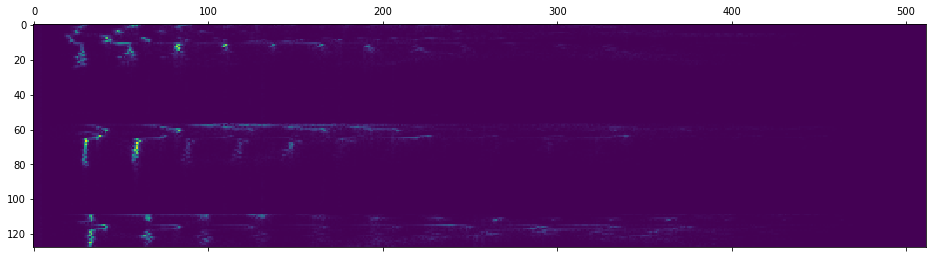

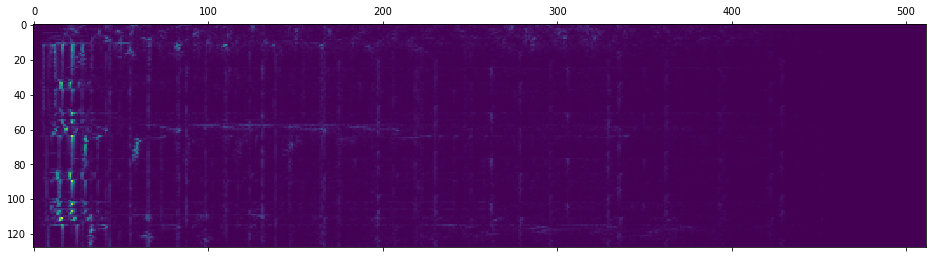

tf.Tensor(702.35205, shape=(), dtype=float32)


In [ ]:
#magmix, magvoice, *_ = preprocess(musdb_train[0])
#X_mix, X_voice = reshape(magmix[:,:,0], magvoice[:,:,0], 128)

plt.matshow(X_voice[0,:,:,0])
plt.show()
plt.matshow(ytest[0,:,:,0])
plt.show()
def myloss(y_true, y_pred):
  return tf.math.reduce_sum(abs(y_true - y_pred)) + abs(tf.math.reduce_sum(y_true) - tf.math.reduce_sum(y_pred))
print(myloss(tf.convert_to_tensor(X_voice[0,:,:,0],dtype=float),tf.convert_to_tensor(ytest[0,:,:,0],dtype=float)))

Possibilité de sauvegarder le réseau obtenu. Nom au format *nom* \_ *date* \_ *clé aléatoire*.

In [ ]:
import secrets
from datetime import datetime

name = "model"
date = datetime.today().strftime('%Y%m%d')
rand_key = secrets.token_hex(8)
full_name = f"{name}_{date}_{rand_key}"

unet.save(os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet",full_name))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projet Datascientest/UNet/model_20220204_ad68bee5553d3270/assets


## Chargement d'un réseau existant

In [ ]:
from tensorflow.keras.models import load_model

model_path = os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet","model_20220101")
unet = load_model(model_path)

# Evaluation du modèle

## Exemple de prédiction

True mix


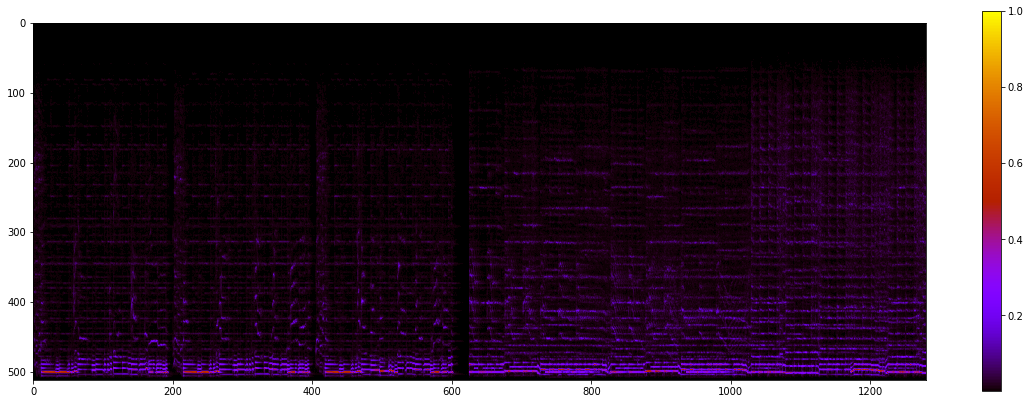

True voice


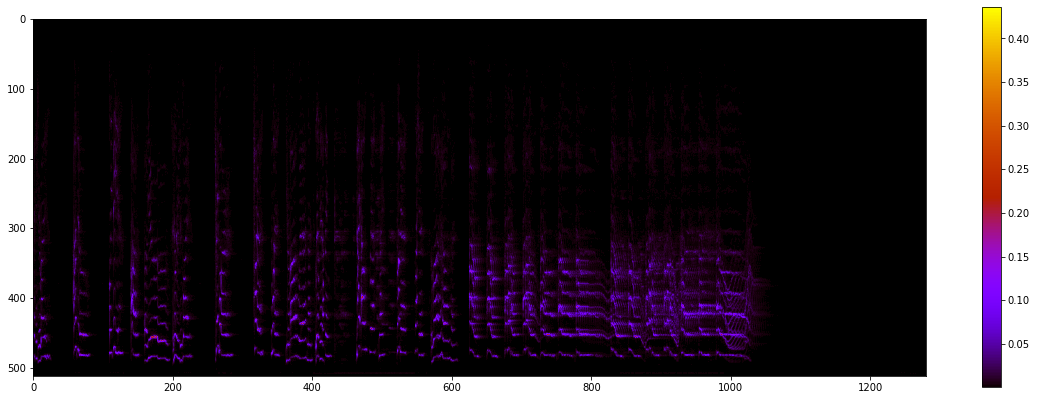

Predicted voice


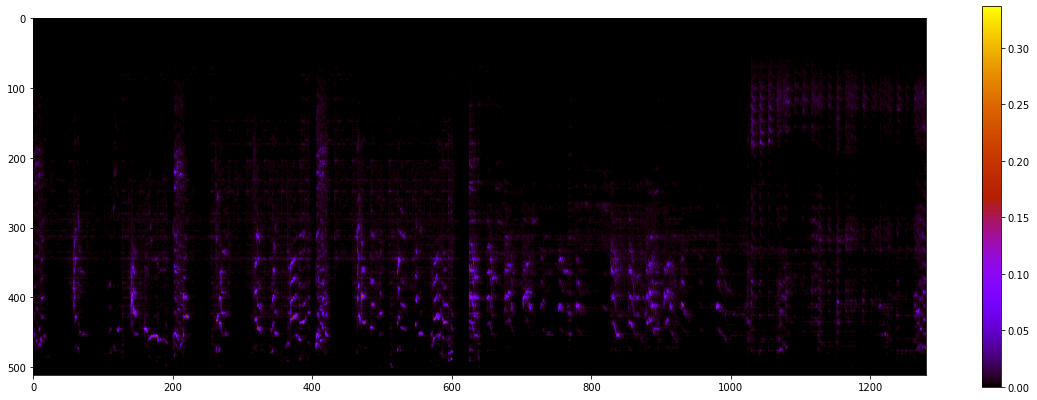

In [ ]:
magmix, magvoice, *_ = preprocess(musdb_train[0])
X_mix, X_voice = reshape(magmix[:,:,0], magvoice[:,:,0], 128)

print("True mix")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_mix[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

print("True voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_voice[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix[0:10,:,:,:].reshape(-1,nframes,nfreq,1))
print("Predicted voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([ytest[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

## Visualisation complète et écoute d'une musique

(512, 2241, 1)
(17, 128, 512, 1)
AudioSignal (unlabeled): 209.908 sec @ AM Contra - Heart Peripheral, 8192 Hz, 1 ch.


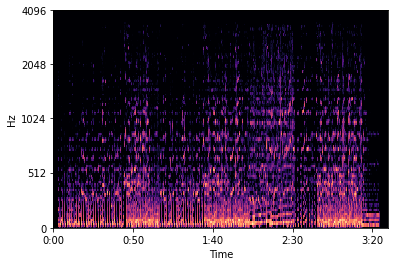

AudioSignal (unlabeled): 209.908 sec @ musdb/AM Contra - Heart Peripheral_vocals.wav, 8192 Hz, 1 ch.


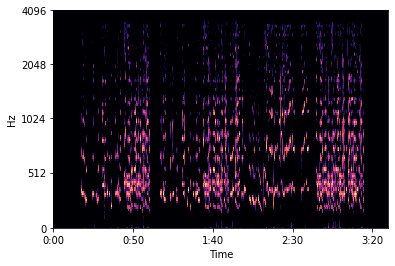

(17, 128, 512, 1)
(512, 2176, 1)
AudioSignal (unlabeled): 203.906 sec @ path unknown, 8192 Hz, 1 ch.


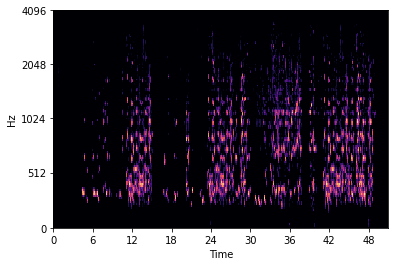

In [ ]:
data = musdb_test[0]

# ATTENTION A UTILISER LES BONS
window_length = 1023
hop_length = 768

magmix, magvoice, phase, norm = preprocess(data)
print(magmix.shape)
X_mix, X_voice = reshape(magmix[:,:,0], magvoice[:,:,0], 128)
print(X_mix.shape)

print(data["mix"])
data["mix"].embed_audio()
nussl.utils.visualize_spectrogram(data["mix"], y_axis='mel')
plt.show()

print(data["sources"]["vocals"])
data["sources"]["vocals"].embed_audio()
nussl.utils.visualize_spectrogram(data["sources"]["vocals"], y_axis='mel')
plt.show()

X_voice_pred =unet.predict(X_mix)
print(X_voice_pred.shape)
magmix_pred = X_voice_pred.reshape(-1,512,1).transpose(1,0,2)
print(magmix_pred.shape)
end = magmix_pred.shape[1]
audio_pred = nussl.AudioSignal(stft=magmix_pred*norm*phase[:,:end],sample_rate=8192)
audio_pred.istft(window_length=window_length,hop_length=hop_length)
print(audio_pred)
audio_pred.embed_audio()
nussl.utils.visualize_spectrogram(audio_pred, y_axis='mel')
plt.show()

